## Linear Regression and project note.

Regression analysis consists of a set of machine learning methods that allow us to predict a continuous outcome variable (y) based on the value of one or multiple predictor variables (x). 

Briefly, the goal of regression model is to build a mathematical equation that defines y as a function of the x variables.

Linear Regression is a machine learning algorithm based on supervised learning. It performs a regression task. Regression models a target prediction value based on independent variables.

A simple Linear Regression fits the model of a straight line:
 
y = ax + b

where a is commonly known as the slope, b is commonly known as the intercept.

x is your independent variables (also referred to as Features). These are the input for a process that is being analyze. 
Y is you dependent variables. These are the output of the process.

In this tutorial, we will use 3 examples to demostrate the use of Linear Regression.

#### Example 1: 

This is a simple Linear Regression with single independent variable (area). In a nutshell, we have to determine the price( dependent variable) of a house based on the area size of the house. 

The data is store in SQL Server tables.



[Tutorial].[dbo].[AreasActualPrice] : This is our trained table, it contains all the live data. 

[Tutorial].[dbo].[AreasPredicted] : This is the test table. We have to determine the value of empty price column.

[Tutorial].[dbo].[AreasPrice] : This is our main final table. It contains both trained(Actual data) and predicted data. The column namely Status contains 2 values. They are Predicted and Actual.


#### Example 2: 

This is a Linear Regression with multiple variables (Multivariate) with data in excel. In a nutshell, we have to determine the price( dependent variable) of a house based on the area size of the house, 
the number of bedrooms and the age of the house. 


#### Example 3: 

This is a Linear Regression with multiple variables (Multivariate) with data in SQL Server tables.
In this case, we have to determine the hiring salary( dependent variable) of a potential employee based on years of experience, test_score_out_of_10 and interview_score_out_of_10.


[Tutorial].[dbo].[ActualHiring] : This is our trained table, it contains all the live data. 

[Tutorial].[dbo].[ActualPredictedHiring] : This is the test table. We have to determine the value of  salary column.





### EXAMPLE 1 : Linear Regression with single variable in SQL Server table

In [408]:
# Example of how to use Linear Regression single variable with data in SQL Server tables
# Import packages
import numpy as np
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import pyodbc

# Step 1: get your data from SQL Server and assign it to a pandas variable
conn_str = pyodbc.connect('Driver={SQL Server};' 'Server=LAPTOP-CHKIB79A;''Database=Tutorial;''Trusted_Connection=yes;')
query_str = "SELECT * FROM [Tutorial].[dbo].[AreasActualPrice]"
df = pd.read_sql(sql=query_str, con=conn_str)
df.head(5)

,Area,Price
0,2600,550000.0
1,3000,565000.0
2,3200,610000.0
3,3600,680000.0
4,4000,725000.0


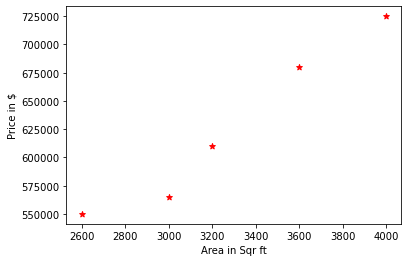

In [409]:
# Step 2: Let's do a quick scatter plot to get an idea of the shape of the data. You need to pass in (x,y) variable
plt.xlabel('Area in Sqr ft')
plt.ylabel('Price in $')
plt.scatter(df.Area,df.Price, color = 'red', marker= '*')

In [410]:
# Step 3: fit your model to use available datasets.
reg = linear_model.LinearRegression() # get linear regression object
reg.fit(df[['Area']],df.Price) # fit your linear regression model. Note that your independent first argument is a 2d array

LinearRegression()

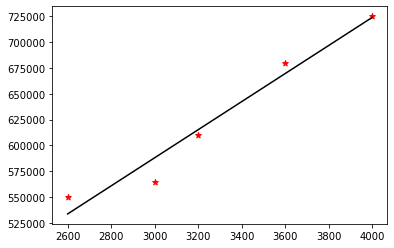

The r-square value is : 0.9584301138199486
Mean square error is : 186815068.4931509
The gradient is :  [135.78767123]
The intercept is : 180616.43835616432


In [411]:
# Step 4 : let's plot the predicted price. Pass in your x variable to a predict function to get y. Note that predict takes 2d array
plt.scatter(df.Area,df.Price, color = 'red', marker= '*')
plt.plot(df.Area,reg.predict(df[['Area']]),color = 'black') # pass in the list array of x into predict to get y
predicted_price = reg.predict(df[['Area']])
gradient = reg.coef_ # this gives you the gradient or slope
intercept = reg.intercept_ # this gives you the intercept on the y axix.

# It is important to know how the relationship between the values of the x-axis and the values of the y-axis is, if there are 
# no relationship, the linear regression can not be used to predict anything. The r-squared value ranges from 0 to 1, where 0 means no relationship, 
# and 1 means 100% related.
r2 = r2_score(df.Price,predicted_price)
mse = mean_squared_error(df.Price,predicted_price)
plt.show()

print("The r-square value is :", r2)
print("Mean square error is :",mse)
print("The gradient is : ",gradient)
print("The intercept is :",intercept)

In [412]:
# Step 5 : Now let's predict the price for any given area. 
# let's get the sql table containing only areas and predict price for each area.
# get your data and assign it to a pandas variable areasize

conn_str = pyodbc.connect('Driver={SQL Server};' 'Server=LAPTOP-CHKIB79A;''Database=Tutorial;''Trusted_Connection=yes;')
myquery_str = "SELECT [Area] FROM [Tutorial].[dbo].[Areas]"
areasize = pd.read_sql(sql=myquery_str, con=conn_str)


# Now, let's get the predicted prices for any given areas.
# remember to go back to your fit model ie reg and pass in variable areasize ( this is your x axix) to your predict function

p = reg.predict(areasize) # this gives you predicted prices that are now assign to variable p.

# now, let us assign p to a newly created column namely PredictedPrices. Note that areasize is actually your pandas variable. It act like a table. you are simply adding
# a newly created PredictedPrices column to Pandas variable table namely areasize.

areasize['PredictedPrices'] = p
print(areasize)

    Area  PredictedPrices
0   1000     3.164041e+05
1   1500     3.842979e+05
2   2300     4.929281e+05
3   3540     6.613048e+05
4   4120     7.400616e+05
5   4560     7.998082e+05
6   5490     9.260908e+05
7   3460     6.504418e+05
8   4750     8.256079e+05
9   2300     4.929281e+05
10  9000     1.402705e+06
11  8600     1.348390e+06
12  7100     1.144709e+06


In [413]:
# Step 6: Let's combine prediction and actual (trained data)  into AreasPrice table. 
# The whole idea here is to get the trained data and predicted data into the same table namely [dbo].[AreasPrice].  
# See next cells for the content of ClearAreasPredicted and LoadAreaPrice Stored Procedure.
cursor = conn_str.cursor()
cursor.execute("EXEC ClearAreasPredicted") # Run SP to truncate table before insertion below.
for i, row in areasize.iterrows():
    cursor.execute("INSERT INTO [Tutorial].[dbo].[AreasPredicted]([Area],[Price]) values(?,?)", row['Area'], row['PredictedPrices'] ) 
cursor.execute("EXEC LoadAreaPrice") # Run SP to load final table. Add status column to differenciate between predicted prices and actual prices
# commit and close connection
conn_str.commit()
cursor.close()
conn_str.close()

In [414]:
''' This is ClearAreasPredicted stored procedure
USE [Tutorial]
GO

SET ANSI_NULLS ON
GO
SET QUOTED_IDENTIFIER ON
GO


CREATE PROCEDURE [dbo].[ClearAreasPredicted]
	
AS
BEGIN
	truncate table  [Tutorial].[dbo].[AreasPredicted]
END
'''


' This is ClearAreasPredicted stored procedure\nUSE [Tutorial]\nGO\n\nSET ANSI_NULLS ON\nGO\nSET QUOTED_IDENTIFIER ON\nGO\n\n\nCREATE PROCEDURE [dbo].[ClearAreasPredicted]\n\t\nAS\nBEGIN\n\ttruncate table  [Tutorial].[dbo].[AreasPredicted]\nEND\n'

In [415]:
''' This is LoadAreaPrice stored procedure
USE [Tutorial]
GO

SET ANSI_NULLS ON
GO
SET QUOTED_IDENTIFIER ON
GO

CREATE PROCEDURE [dbo].[LoadAreaPrice]
	
AS
BEGIN

TRUNCATE TABLE [dbo].[AreasPrice];
INSERT INTO [dbo].[AreasPrice]
	SELECT  [Area]
      ,[Price],  
      'Actual' As Status
  FROM [Tutorial].[dbo].[AreasActualPrice]

UNION

SELECT  [Area]
      ,[Price],  
      'Predicted' As Status
  FROM [Tutorial].[dbo].[AreasPredicted]
END
'''

" This is LoadAreaPrice stored procedure\nUSE [Tutorial]\nGO\n\nSET ANSI_NULLS ON\nGO\nSET QUOTED_IDENTIFIER ON\nGO\n\nCREATE PROCEDURE [dbo].[LoadAreaPrice]\n\t\nAS\nBEGIN\n\nTRUNCATE TABLE [dbo].[AreasPrice];\nINSERT INTO [dbo].[AreasPrice]\n\tSELECT  [Area]\n      ,[Price],  \n      'Actual' As Status\n  FROM [Tutorial].[dbo].[AreasActualPrice]\n\nUNION\n\nSELECT  [Area]\n      ,[Price],  \n      'Predicted' As Status\n  FROM [Tutorial].[dbo].[AreasPredicted]\nEND\n"

In [416]:
# Let's see the content of our final table containing both actual (trained data) and predicted data.
conn_str1 = pyodbc.connect('Driver={SQL Server};' 'Server=LAPTOP-CHKIB79A;''Database=Tutorial;''Trusted_Connection=yes;')
query_str1 = "SELECT * FROM [Tutorial].[dbo].[AreasPrice]"
dftest = pd.read_sql(sql=query_str1, con=conn_str1)
dftest.head(8)

,Area,Price,Status
0,1000,316404.109589,Predicted
1,1500,384297.945205,Predicted
2,2300,492928.082192,Predicted
3,2600,550000.000000,Actual
4,3000,565000.000000,Actual
5,3200,610000.000000,Actual
6,3460,650441.780822,Predicted
7,3540,661304.794521,Predicted


In [417]:
# commit and close connection
conn_str1.commit()
conn_str1.close()

In [418]:
# Step 7: Finally you can save your model (reg) to a file using pickle. You can now give this file to your work colleague to make prediction.
# save your model to a writable binary (wb) and call dump function to write it to the specified path
import pickle
with open('C:\Python\My Files\model_pickle','wb') as f:
    pickle.dump(reg,f)
# read binary (rb) file and call load function to read from the file
with open('C:\Python\My Files\model_pickle','rb') as f:
    mp = pickle.load(f)
# now, let's test our model to predict the price for an area of 3000
print("Predicted price for an area of 3000 is :",mp.predict([[3000]]))

Predicted price for an area of 3000 is : [587979.45205479]


In [419]:
# Step 8: You can now give model_pickle file to your colleaque. He or she will save it to a drive and can then run it in say Jupyter Notebook to make prediction.
# Your colleaque will simply have to call the load function to open the file given to them and save this into a variable as shown below.

import pickle

var = pickle.load(open('C:\Python\My Files\model_pickle','rb'))
print("Predicted value :",var.predict([[3000]]))
print("My gradient is :" ,var.intercept_)
print("My coefficient is :", var.coef_)

Predicted value : [587979.45205479]
My gradient is : 180616.43835616432
My coefficient is : [135.78767123]


### EXAMPLE 2 : Linear Regression with multiple variables (Multivariate) with data in excel

In [420]:
# Example of how to use Linear Regression multiple variable (Multivariate) with data in excel
import numpy as np
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import pyodbc
import math

# Step 1: get your data from excel file and assign it to a pandas variable
df = pd.read_csv("C:\Python\My Files\homeprices_2.csv")
df.head()

,area,bedrooms,age,price
0,2600,3.0,20,550000
1,3000,4.0,15,565000
2,3200,NaN,18,610000
3,3600,3.0,30,595000
4,4000,5.0,8,760000


In [421]:
# let's do some data cleaning to replace the null value in bedrooms with the aveage bedroom size.
#let's get the average bedroom size
mean_bedrooms = df.bedrooms.mean()

#let's round this up to an interger
mean_bedrooms = math.floor(mean_bedrooms)

#let's fill in all the null values in bedrooms size with the aveage value above and assign the filled value back to our original bedroom
df.bedrooms = df.bedrooms.fillna(mean_bedrooms)
df.bedrooms.head()

0    3.0
1    4.0
2    4.0
3    3.0
4    5.0
Name: bedrooms, dtype: float64

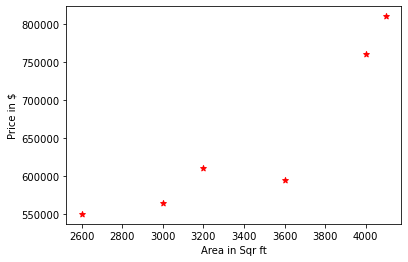

In [422]:
# Step 2: Let's do a quick scatter plot to get an idea of the shape of the data. Test individual independent variable one by one ie area as shown below.

#let's test the shape of the area
plt.xlabel('Area in Sqr ft')
plt.ylabel('Price in $')
plt.scatter(df.area,df.price, color = 'red', marker= '*')

In [423]:
# Step 3: fit your model to use available datasets.
reg = linear_model.LinearRegression() # get linear regression object
reg.fit(df[['area','bedrooms','age']],df.price) # fit your linear regression model. Note that your independent first argument is a 2d array

# Step 4 : let's get the predicted price. Pass in your x variable to a predict function to get y. Note that predict takes 2d array
predicted_price = reg.predict(df[['area','bedrooms','age']])
gradient = reg.coef_ # this gives you the gradient or slope
intercept = reg.intercept_ # this gives you the intercept on the y axix.

# It is important to know how the relationship between the values of the x-axis and the values of the y-axis is, if there are 
# no relationship the linear regression can not be used to predict anything. The r-squared value ranges from 0 to 1, where 0 means no relationship, 
# and 1 means 100% related.
r2 = r2_score(df.price,predicted_price)
mse = mean_squared_error(df.price,predicted_price)

print("The r-square value is :", r2)
print("Mean square error is :",mse)
print("The gradient is : ",gradient)
print("The intercept is :",intercept)

The r-square value is : 0.9550196399325818
Mean square error is : 446305128.22449404
The gradient is :  [  112.06244194 23388.88007794 -3231.71790863]
The intercept is : 221323.00186540443


In [424]:
# Step 5: Now let's get the price prediction for 
# 3000sq feet area, 3 bedrooms and 40 years old house and 
# 2500sq feet area, 4 bedrooms and 5 years old house

priceprediction = reg.predict([[3000,3,40],[2500,4,5]])
print("The predictions are :" ,priceprediction)

The predictions are : [498408.25158031 578876.03748933]


### EXAMPLE 3 : Linear Regression with multiple variables (Multivariate) with data in SQL Server table

In [425]:
# This is a good example of how to use Linear Regression multiple variable (Multivariate)  with data in SQL Server tables
import numpy as np
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import pyodbc
from word2number import w2n
import math

# Step 1: get your data from SQL Server and assign it to a pandas variable
conn_str = pyodbc.connect('Driver={SQL Server};' 'Server=LAPTOP-CHKIB79A;''Database=Tutorial;''Trusted_Connection=yes;')
query_str = "SELECT * FROM [Tutorial].[dbo].[ActualHiring]"
df = pd.read_sql(sql=query_str, con=conn_str)
df.head(10)

,experience,test_score_out_of_10,interview_score_out_of_10,salary
0,None,8.0,9,50000
1,None,8.0,6,45000
2,five,6.0,7,60000
3,two,10.0,10,65000
4,seven,9.0,6,70000
5,three,7.0,10,62000
6,ten,NaN,7,72000
7,eleven,7.0,8,80000


In [426]:
# Now, let's sort out the data quality issues by filling null with zero
df.experience = df.experience.fillna("Zero")
df.head(10)

,experience,test_score_out_of_10,interview_score_out_of_10,salary
0,Zero,8.0,9,50000
1,Zero,8.0,6,45000
2,five,6.0,7,60000
3,two,10.0,10,65000
4,seven,9.0,6,70000
5,three,7.0,10,62000
6,ten,NaN,7,72000
7,eleven,7.0,8,80000


In [427]:
# Now, let's convert word numbers to numerical numbers for experience column
df.experience = df.experience.apply(w2n.word_to_num)
df.head(10)

,experience,test_score_out_of_10,interview_score_out_of_10,salary
0,0,8.0,9,50000
1,0,8.0,6,45000
2,5,6.0,7,60000
3,2,10.0,10,65000
4,7,9.0,6,70000
5,3,7.0,10,62000
6,10,NaN,7,72000
7,11,7.0,8,80000


In [428]:
# let's sort out null value in test_score_out_of_10 column
# get the average value for test_score_out_of_10
test_score_updated = df.test_score_out_of_10.mean()
print("The aveage test_score_out_of_10 is :",  test_score_updated)
# convert the average value to integer
test_score_updated = math.floor(test_score_updated)
print("The aveage integer test_score_out_of_10 is :",  test_score_updated)
# fill the null value in the column with the new average value
df.test_score_out_of_10 = df.test_score_out_of_10.fillna(test_score_updated)
df.head()

The aveage test_score_out_of_10 is : 7.857142857142857
The aveage integer test_score_out_of_10 is : 7


,experience,test_score_out_of_10,interview_score_out_of_10,salary
0,0,8.0,9,50000
1,0,8.0,6,45000
2,5,6.0,7,60000
3,2,10.0,10,65000
4,7,9.0,6,70000


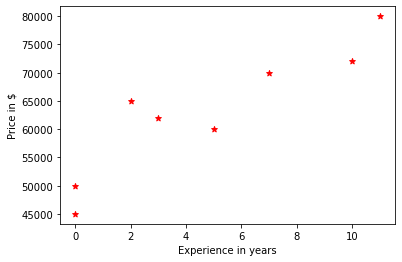

In [429]:
# Step 2: Let's do a quick scatter plot to get an idea of the shape of the data. Test individual independent variable one by one ie area as shown below.
plt.xlabel('Experience in years')
plt.ylabel('Price in $')
plt.scatter(df[['experience']],df.salary, color = 'red', marker= '*')

In [430]:
# Step 3: fit your model to use available datasets.
reg = linear_model.LinearRegression() # get linear regression object
reg.fit(df[['experience','test_score_out_of_10','interview_score_out_of_10']],df.salary) # fit your linear regression model. Note that your independent first argument is a 2d array

# Step 4 : let's get the predicted salary. Pass in your x variable to a predict function to get y. Note that predict takes 2d array
predicted_salary = reg.predict(df[['experience','test_score_out_of_10','interview_score_out_of_10']])
gradient = reg.coef_ # this gives you the gradient or slope
intercept = reg.intercept_ # this gives you the intercept on the y axix.

# It is important to know how the relationship between the values of the x-axis and the values of the y-axis is, if there are 
# no relationship the linear regression can not be used to predict anything. The r-squared value ranges from 0 to 1, where 0 means no relationship, 
# and 1 means 100% related.
r2 = r2_score(df.salary,predicted_salary)
mse = mean_squared_error(df.salary,predicted_salary)

print("r2_score is :",r2)
print("mean_squared_error is :",mse)
print("gradients are :" ,gradient)
print("intercept is :",intercept)

r2_score is : 0.977013901427314
mean_squared_error is : 2660640.909788399
gradients are : [2922.26901502 2221.30909959 2147.48256637]
intercept is : 14992.651446693148


In [431]:
# Step 5 : Now let's predict the salary for any given experience,test_score_out_of_10 and interview_score_out_of_10. 
# let's get the sql table  and predict salary for the independent variables
# get your data and assign it to a pandas variable myvars

conn_str = pyodbc.connect('Driver={SQL Server};' 'Server=LAPTOP-CHKIB79A;''Database=Tutorial;''Trusted_Connection=yes;')
myquery_str = "SELECT  [experience] ,[test_score_out_of_10],[interview_score_out_of_10] FROM [Tutorial].[dbo].[PredictedHiring]"
myvars = pd.read_sql(sql=myquery_str, con=conn_str)
myvars.head()

,experience,test_score_out_of_10,interview_score_out_of_10
0,2,9,6
1,12,10,10
2,4,6,6
3,5,7,8
4,6,8,0


In [432]:
# Now, let's get the predicted salaries for all independent variables stored in myvars.
# remember to go back to your fit model ie reg and pass in variable myvars ( this is your x axix) to your predict function

p = reg.predict(myvars) # this gives you predicted prices that are now assign to variable p.

print("Predicted salaries are :", p)

Predicted salaries are : [53713.86677124 93747.79628651 52894.47750251 62333.02074986
 50296.73833353 80612.19757549 58680.56810626]


In [433]:
# now, let assign p to a newly created column namely PredictedSalaries. Note that myvars is actually your pandas variable. It act like a table. You are simply adding
# a newly created PredictedSalaries column to Pandas variable table namely myvars.

myvars['PredictedSalaries'] = p
myvars.head(8)

,experience,test_score_out_of_10,interview_score_out_of_10,PredictedSalaries
0,2,9,6,53713.866771
1,12,10,10,93747.796287
2,4,6,6,52894.477503
3,5,7,8,62333.020750
4,6,8,0,50296.738334
5,9,9,9,80612.197575
6,0,10,10,58680.568106


In [434]:
# The next step is to map your pandas columns to the columns in your sql table namely PredictedHiring
# use the connection string to call cursor() function
cursor = conn_str.cursor()
cursor.execute("truncate table  [Tutorial].[dbo].[ActualPredictedHiring]")  #truncate table before insertion
for i, row in myvars.iterrows():
    cursor.execute("INSERT INTO [Tutorial].[dbo].[ActualPredictedHiring]([experience],[test_score_out_of_10],[interview_score_out_of_10],[salary] ) \
    values(?,?,?,?)", row['experience'], row['test_score_out_of_10'],row['interview_score_out_of_10'],row['PredictedSalaries'] ) 


conn_str.commit()
cursor.close()
conn_str.close()

In [435]:
# Let us look at the content of our final populated prediction table in SQL Server Management Studio.
conn_str1 = pyodbc.connect('Driver={SQL Server};' 'Server=LAPTOP-CHKIB79A;''Database=Tutorial;''Trusted_Connection=yes;')
query_str1 = "SELECT * FROM [Tutorial].[dbo].[ActualPredictedHiring]"
dftest = pd.read_sql(sql=query_str1, con=conn_str1)
dftest.head(10)

,experience,test_score_out_of_10,interview_score_out_of_10,salary
0,2,9,6,53713
1,12,10,10,93747
2,4,6,6,52894
3,5,7,8,62333
4,6,8,0,50296
5,9,9,9,80612
6,0,10,10,58680


In [436]:
# Comit and close connections
conn_str1.commit()
conn_str1.close()